In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
autoreload 2

In [4]:
import matplotlib.pyplot as plt
from scipy import stats, optimize
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division
#from sympy import init_printing

In [5]:
from estimation_class2 import *

# Estimation for Spain

## Production function:

### $$ A_s * Big A * (\omega_A  * x^{\frac{\sigma-1}{\sigma}}+(1-\omega_A)  * y^{\frac{\sigma-1}{\sigma}} )^{\frac{\sigma}{\sigma-1}} * l^{\omega_B} * r^{(1-\omega_B)} $$

**Parameter restrictions**:
- $\omega_B > \omega_A $: This makes sure that bigger firms hire better workers.
- $\sigma < 1 $: This ensures PAM.

Finally, $A_s$ is a scaling factor for $Big A$. As  $Big A$ can get quite big, for the minimizing routine it is best to first scale it up by A_s and then letting the minimization work with similar quantities as the parameters.

###This imports the code, stores the data and dispalys it:

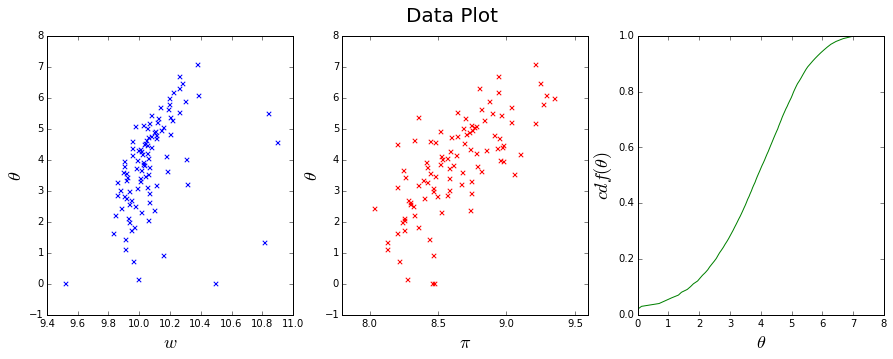

In [6]:
knots= np.logspace(np.log(0.005), np.log(200.0), 1000,endpoint=True, base=np.e)
est1 = HTWF_Estimation((0.0,1.0), (0.005, 20.0), (0.0,1.0), (0.005, 20.0), 142.85, 100000.0, knots)
est1.InitializeFunction()
est1.import_data('SPA05.csv', ID=False, weights=False, logs=False, yearly_w=True)
est1.Plot_data()

In [15]:
besties = (0.63023927,  0.8037265,   0.67336212,  1.33407531)
# try it out   
F_params = {'omega_A':besties[0], 'omega_B':besties[1], 'sigma_A':besties[2], 'Big_A':besties[3]}
functions_f_model = est1.Solve_Model(F_params, None, 'vode', 1e3, 1e-3)
est1.Plot_solution()

AssertionError: Fail to solve!

So we have:

- A relationship between (annual) log wages and log firm size.
- A relationship between (annual) log profits and log firm size.
- A distribution of log firm size.

The model spits out:
- A function that relates $wage \to \theta$ (not in logs, we take them when calculating the error)
- A function that relates $\pi \to \theta$ (not in logs, we take them when calculating the error) 
- The gridgpoints of $x$ with their corresponding $\theta$s. From there we build the distribution via:$ \frac{pdf(x_i)}{\theta_i} = pdf(\theta_i)$ (plus take logs and normalize)


### The objective function:

##$$ min_{{\omega_A,\omega_B,\sigma,Big_A}} \sum_i{(\theta_i - \hat\theta_i(wage_i))^2 + (\theta_i - \hat\theta_i(\pi_i))^2 + (cdf_{\theta}(\theta_i) - \hat{cdf}_{\theta}(\theta_i))^2}$$

There is a penalty of **100.0** for not having some points in the solution (so data points smaller than the smallest size from the model or data points bigger than the biggest size from the model). We can change this in the future.

### The following puts everything into the minimization routine

About the minimization routine, this is the best one we've found so far in python. It takes a while because you can't simply take derivatives of the objective function. Next week we'll look up alternatives / ways to make the solver faster and more precise.

In [13]:
ps = (0.63023927,  0.8037265,   0.67336212,  1.33407531)
# constraints (w_b>w_a)
cons = ({'type': 'ineq',
         'fun' : lambda ps: np.array([ps[1]- ps[0]]),
         'jac' : lambda ps: np.array([-1.0, 1.0, 0.0, 0.0])})
res = optimize.minimize(est1.StubbornObjectiveFunction, ps, args=(None, 1e-3, 1e4),
               bounds=((1e-2,1.0-1e-2),(1e-2,1.0-1e-2),(1e-2,1.0-1e-2),(0.5,2.0)),
               constraints=cons, method='SLSQP', options={'disp': True})

K. [ 0.63023927  0.8037265   0.67336212  1.33407531] error: Fail to solve!
K. [ 0.63023927  0.8037265   0.67336212  1.33407531] error: Fail to solve!
K. [ 0.63023928  0.8037265   0.67336212  1.33407531] error: Fail to solve!
K. [ 0.63023927  0.80372651  0.67336212  1.33407531] error: Fail to solve!
K. [ 0.63023927  0.8037265   0.67336213  1.33407531] error: Fail to solve!
K. [ 0.63023927  0.8037265   0.67336212  1.33407532] error: Fail to solve!
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 14332723.2
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


In [10]:
est1.write_solution_path()

Although this particular run didn't succeed, I have one case of success. The lowest point so far is is given by:
     
$$ \omega_A :0.59031046 , \omega_B :0.78435585, \sigma_A :0.74916621, Big_A :1.25752894 $$

Below is represented the fit to the data.

In [12]:
besties = (0.63023927,  0.8037265,   0.67336212,  1.33407531)
# try it out   
F_params = {'omega_A':besties[0], 'omega_B':besties[1], 'sigma_A':besties[0], 'Big_A':besties[0]}
functions_f_model = est1.Solve_Model(F_params, None, knots,'vode', 1e3, 1e-3)

Success! All workers and firms are matched


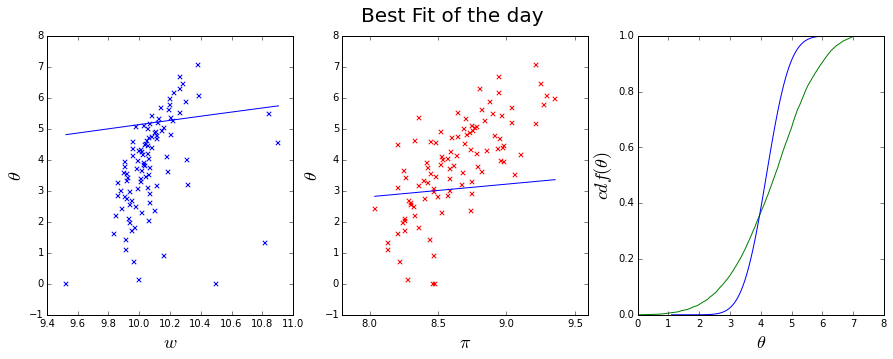

In [13]:
est1.Plot_solution()

Note: remember that everythging is in logs, so althought the functions from the model seem linear, they are not.

Not a great job for profits and wages (wages from the model tend to be way smaller than profits, and in may data the profit is the "retribution to the entrepreneur" - which is a salary to him at the end of the day). The distribution of firm sizes is pretty good. The median seems to be a hit.